In [6]:

import os
import urllib.request
import ssl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# Disable SSL verification for urllib
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
# Set your class labels
CLASSES = ['cat', 'diamond', 'eye', 'ladder', 'moon', 'necklace', 'snowflake', 'sword', 'tornado', 'watermelon']
DATASET_DIR = './dataset'
SAMPLES_PER_CLASS = 20000
IMG_SIZE = 28

In [9]:
def download_quickdraw_data(classes):
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    os.makedirs(DATASET_DIR, exist_ok=True)

    for cls in classes:
        file_path = os.path.join(DATASET_DIR, f'full_numpy_bitmap_{cls}.npy')
        if not os.path.exists(file_path):
            print(f"Downloading: {cls}")
            cls_url = base_url + cls.replace('_', '%20') + '.npy'
            urllib.request.urlretrieve(cls_url, file_path)
        else:
            print(f"{cls} already downloaded.")


In [10]:

# Load and preprocess data
def load_data(classes, samples_per_class, test_split=0.2):
    download_quickdraw_data(classes)

    train_data, train_labels = [], []
    test_data, test_labels = [], []

    for label_index, cls in enumerate(classes):
        path = os.path.join(DATASET_DIR, f'full_numpy_bitmap_{cls}.npy')
        data = np.load(path)[:samples_per_class]
        split_idx = int(len(data) * (1 - test_split))

        train_data.append(data[:split_idx])
        train_labels += [label_index] * split_idx

        test_data.append(data[split_idx:])
        test_labels += [label_index] * (len(data) - split_idx)

    train_data = np.concatenate(train_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    test_data = np.concatenate(test_data).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
    train_labels_cat = to_categorical(np.array(train_labels), num_classes=len(classes))
    test_labels_cat = to_categorical(np.array(test_labels), num_classes=len(classes))

    return train_data, train_labels_cat, test_data, test_labels_cat, train_labels, test_labels


In [11]:
# Build the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=input_shape),
        Conv2D(16, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(16, (5, 5), padding='same', activation='relu'),
        Conv2D(32, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(32, (5, 5), padding='same', activation='relu'),
        Conv2D(64, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),

        Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
        Dense(256, activation="relu", kernel_regularizer=l2(0.01)),
        Dense(num_classes, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model



In [12]:
# Load data
train_data, train_labels_cat, test_data, test_labels_cat, train_labels, test_labels = load_data(CLASSES, SAMPLES_PER_CLASS)


Downloading: cat
Downloading: diamond
Downloading: eye
Downloading: ladder
Downloading: moon
Downloading: necklace
Downloading: snowflake
Downloading: sword
Downloading: tornado
Downloading: watermelon


In [13]:
# Build model
model = build_model((IMG_SIZE, IMG_SIZE, 1), len(CLASSES))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,866 (1.01 MB)

 Trainable params: 265,866 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels_cat, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=200)


Epoch 1/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 313s 489ms/step - accuracy: 0.8641 - loss: 0.5344 - val_accuracy: 0.9263 - val_loss: 0.2727
Epoch 2/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 314s 491ms/step - accuracy: 0.9153 - loss: 0.3195 - val_accuracy: 0.9302 - val_loss: 0.2483
Epoch 3/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 322s 491ms/step - accuracy: 0.9207 - loss: 0.2929 - val_accuracy: 0.9304 - val_loss: 0.2481
Epoch 4/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 322s 490ms/step - accuracy: 0.9285 - loss: 0.2707 - val_accuracy: 0.9383 - val_loss: 0.2259
Epoch 5/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 317s 496ms/step - accuracy: 0.9320 - loss: 0.2551 - val_accuracy: 0.9410 - val_loss: 0.2182
Epoch 6/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 311s 486ms/step - accuracy: 0.9357 - loss: 0.2425 - val_accuracy: 0.9419 - val_loss: 0.2098
Epoch 7/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 313s 488ms/step - accuracy: 0.9358 - loss: 0.2364 - val_accuracy: 0.9442 - val_loss: 0.2095
Epoch 8/20
640/640 ━━━━━━━━━━━━━━━━━━━━ 320s 485ms/step - accuracy: 0.9382 -

In [16]:
# Evaluate
_, train_acc = model.evaluate(train_data, train_labels_cat)
print(f"Train Accuracy: {train_acc:.2f}")

_, test_acc = model.evaluate(test_data, test_labels_cat)
print(f"Test Accuracy: {test_acc:.2f}")


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 109s 22ms/step - accuracy: 0.9676 - loss: 0.1204
Train Accuracy: 0.96
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.9570 - loss: 0.1662
Test Accuracy: 0.95


In [17]:
model.save("QuickDrawCNN.h5")
print("Model saved as QuickDrawCNN.h5")

Model saved as QuickDrawCNN.h5


In [18]:
model.save("QuickDrawCNN.keras")
print("Model saved as QuickDrawCNN.keras")

Model saved as QuickDrawCNN.keras


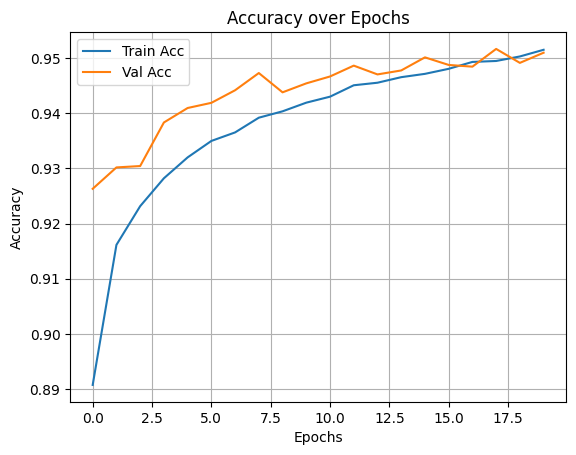

In [19]:
# Plot accuracy
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

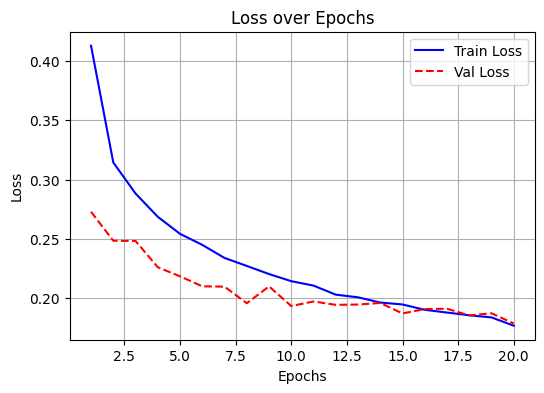

In [20]:
# Plotting Training and Validation Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Generating Confusion Matrix...
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step


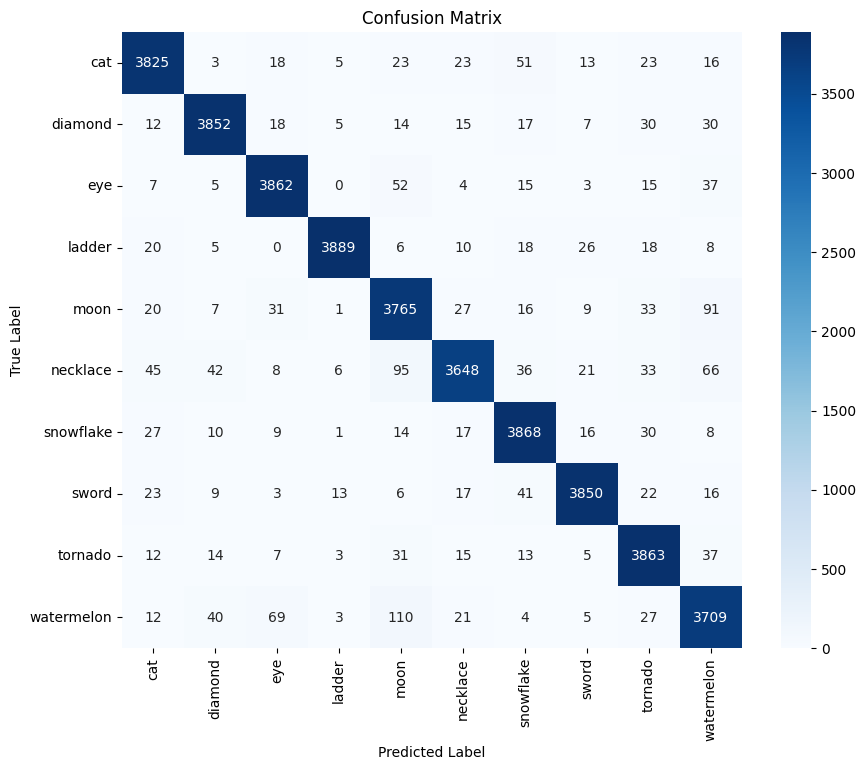

In [21]:
# CONFUSION MATRIX PLOT
print("\nGenerating Confusion Matrix...")

# Predict and decode class labels
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = np.array(test_labels)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
#  Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))


Classification Report:
              precision    recall  f1-score   support

         cat       0.96      0.96      0.96      4000
     diamond       0.97      0.96      0.96      4000
         eye       0.96      0.97      0.96      4000
      ladder       0.99      0.97      0.98      4000
        moon       0.91      0.94      0.93      4000
    necklace       0.96      0.91      0.94      4000
   snowflake       0.95      0.97      0.96      4000
       sword       0.97      0.96      0.97      4000
     tornado       0.94      0.97      0.95      4000
  watermelon       0.92      0.93      0.93      4000

    accuracy                           0.95     40000
   macro avg       0.95      0.95      0.95     40000
weighted avg       0.95      0.95      0.95     40000



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
True Label: tornado
Predicted Label: tornado


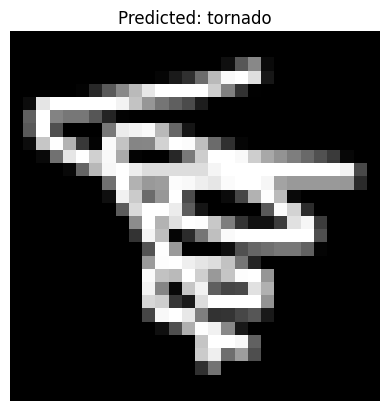

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Predict a random sample
index = np.random.randint(0, len(test_data))
sample = test_data[index].reshape(1, 28, 28, 1)  # Reshape for prediction

prediction = model.predict(sample)
predicted_class = np.argmax(prediction)

true_class = np.argmax(test_labels_cat[index])

print(f"True Label: {CLASSES[true_class]}")
print(f"Predicted Label: {CLASSES[predicted_class]}")

# Show the image
plt.imshow(sample[0, :, :, 0], cmap='gray')
plt.title(f"Predicted: {CLASSES[predicted_class]}")
plt.axis('off')
plt.show()


In [25]:
from keras.models import load_model

# Load model
model = load_model('QuickDrawCNN.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_data, test_labels_cat, verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.9570 - loss: 0.1662
Test Accuracy: 0.95
